# So you’ve generated the data … now what? Bioinformatics and data science for the bench scientist<a class="tocSkip">
This is the notebook for the hands-on demonstration part of the breakout. All other breakout materials can be found in this <a href="https://drive.google.com/drive/u/1/folders/1bOhsP4uwa-OTB_yEyYRRhKBSUZ1jCSQN">google drive</a>.
    
# Notebook overview
<font color = "black">This notebook walks you through handling RNA-seq data that has been (pseudo) aligned (slide 18 for an alignment workflow) to a transcriptome using Kallisto (slides 21-27,29).  The pseudoalignment was performed  on-prem on the Broad's server space (but see slides 27 and 28 for some guidance to do pseudoalignment on Terra).  From these quantified data (slide 37-39), we will

1. Read in the data
1. Normalize for read depth (slide 38)
1. Identify differentially expressed genes (DEG)
1. Make several plots (slide 40)

The raw data was kindly provided to us by the <a href="https://www.ellinorlab.org/">Ellinor lab</a>!  The data is from the left ventricles of mice that are either wild type or have had the gene Cand2 (involved in ubiquitin proteasome degradation) knocked out in a heart-specific manner.
    
While this notebook tutorial has been in development for several years, it is largely based on <a href="https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html">this excellent tutorial on DEseq2</a> by Michael Love.</font>

# Stage data in the cloud 
<font color="#445555">When working in Terra, all data needs to be staged in the cloud either in workspace cloud storage or in an external Google bucket. The code below unloads data from on prem storage to workspace cloud storage (Google bucket).  

<font color="#445555">**Note that this has been done in advance, so you don't have to run this code today!**
    
<font color="#445555">**To see the full code block**    
<font color="#445555">Click on the small grey arrow at the left or the purple arrow to the right. Note that the code is collapsed to keep it from being distracting. 

In [ ]:
# Preflight unix commands on Broad prem server
# /medpop/afib/ahall/CAND2_plots/quant_tximport/ -- on prem
# Note that this in all in the unix command line environment
###########################################################
## Load software packages using DotKit (see broad.io/dotkit)
#use .google-cloud-sdk
## Copy data to Google bucket
#gsutil cp -r quant_output_6636_LV_KO gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp -r quant_output_6691_LV_KO gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp -r quant_output_6692_LV_KO gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp -r quant_output_6693_LV_WT gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp -r quant_output_6694_LV_WT gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp -r quant_output_6695_LV_WT gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp tximport_sample_LV.txt gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp mmusculus_tx2gene.txt gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport
#gsutil cp mmusculus_gene2goTerm.txt gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport

# Environment setup

<font color="#445555">You will need to install packages that are not already included in the Cloud Environment Application configuration.   

<font color="#445555">**Why is this necessary?**    
<font color="#445555">Including this step directly in the notebook ensures than anyone who runs the analysis has the same computational envioronment.    

#### <font color="#FF6600">(expand for tip) </font> <font color="#445555">How do you run a code block?</font><a class="tocSkip">

<div style="color: #445555;">Notebooks have *documentation cells* and *code block cells*. You can tell which cell type a cell is by clicking the cell (this will highlight the current cell) and looking at what's in the dropdown in the notebook navigation menu (below the `Navigate` menu item). <br/>
    
1. Click the code block cell you want to run
1. Click '&#9654; Run' in the notebook navigation menu to execute the code
    1. TIP: Use <kbd>shift</kbd> + <kbd>enter</kbd> as a shortcut
</div>

In [1]:
# Define a time saving function for package installation, via:
#https://app.terra.bio/#workspaces/fc-product-demo/Terra-Notebooks-Quickstart/notebooks/launch/1_R_environment_setup.ipynb
install_if_missing <- function(packages) {
    if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
        install.packages(setdiff(packages, rownames(installed.packages())))
    }
}

#### <font color="#FF6600">(expand for tip) </font> <font color="#445555">How do know your when a code cell is running? Is complete?</font><a class="tocSkip">

**<font color="#445555">Running code cells</font>**    
<font color="#445555">1. There will be an `*` in between the brackets at the top left corner of the code cell: `In [*]`. </font>   
<font color="#445555">2. The section with the code cell will be highlighted in red in the Table of Contents</font>    

**<font color="#445555">Completed code cells</font>**    
<font color="#445555">1. The `*` will turn into a number (`In [*]` will become `In [3]` for example)</font>   
<font color="#445555">2. You may get some output information (in black text on either white or pink background). Note that a pink warning message does not necessarily mean your notebook is broken!</font>

## Install packages using base R and BiocManager

In [2]:
# Install packages
install_if_missing(c('readr','lattice', 'gplots', 'ggplot2', 'RColorBrewer','tidyr','plyr','dplyr', 'reshape2','scales'))

# Install Bioconductor packages
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("DESeq2") #for handling DE gene analysis on our data
BiocManager::install("tximport") #for reading external transcript files into DEseq2
BiocManager::install("rhdf5") #for reading h5 files, the file format of kallisto output quantifications
BiocManager::install("EnhancedVolcano")#for volcano plotting
BiocManager::install("biomaRt") #for getting human gene data to roll transcripts into gene level quantification
BiocManager::install("apeglm") #for processing DEseq2 data
BiocManager::install("topGO") #for pathway enrichment using the gene ontologies
BiocManager::install("Rgraphviz") #for creating plots


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cloud.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'DESeq2'”
Old packages: 'bbmle', 'brio', 'bslib', 'cli', 'cluster', 'cpp11', 'crosstalk',
  'curl', 'data.table', 'dbplyr', 'deldir', 'desc', 'dplyr', 'dqrng', 'DT',
  'evaluate', 'fansi', 'filelock', 'foreign', 'GenomicRanges', 'gert',
  'ggplot2', 'ggrepel', 'gtools', 'haven', 'htmltools', 'htmlwidgets',
  'httpuv', 'httr2', 'igraph', 'interp', 'jsonlite', 'knitr', 'later',
  'lattice', 'leiden', 'lifecycle', 'Matrix', 'matrixStats', 'nlme',
  'pkgbuild', 'plotly', 'processx', 'progress', 'ragg', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'reticulate', 'rlang', 'rpart', 'rprojroot', 'RSQLite',
  'R

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'topGO'”
Old packages: 'bbmle', 'brio', 'bslib', 'cli', 'cluster', 'cpp11', 'crosstalk',
  'curl', 'data.table', 'dbplyr', 'deldir', 'desc', 'dplyr', 'dqrng', 'DT',
  'evaluate', 'fansi', 'filelock', 'foreign', 'GenomicRanges', 'gert',
  'ggplot2', 'ggrepel', 'gtools', 'haven', 'htmltools', 'htmlwidgets',
  'httpuv', 'httr2', 'igraph', 'interp', 'jsonlite', 'knitr', 'later',
  'lattice', 'leiden', 'lifecycle', 'Matrix', 'matrixStats', 'nlme',
  'pkgbuild', 'plotly', 'processx', 'progress', 'ragg', 'RcppArmadillo',
  'RcppEigen', 'RCurl', 'reticulate', 'rlang', 'rpart', 'rprojroot', 'RSQLite',
  'Rtsne', 'sass', 'scales', 'sctransform', 'scuttle', 'Seurat',
  'SeuratObject', 'shiny', 'sp', 'spatstat.data', 'spatstat.explore',
  'spatstat.geom', 'spatstat.random', 'spatstat.sparse', 'spatstat

#### <font color="#FF6600">(expand for tip) </font>  <font color="#445555">If you get a pink warning when running the code above<a class="tocSkip">

<font color="#445555">The pink output is just the virtual machine telling you something. Often, it's a warning that you can ignore - it won't break the analysis.

## Load packages into the virtual machine (VM) environment
<font color="#445555">The next code block cell loads in packages for  
    1. Wrangling data   
    2. Plotting   
    3. Pathway analysis

In [3]:
# Load packages for data wrangling 
library(DESeq2)
library(tximport)
library(rhdf5)
library(readr)
library(biomaRt)

# Load packages for plotting
library(EnhancedVolcano) #for volcano plotting, later
library(ggplot2)
library(RColorBrewer)
library(lattice)
library(gplots)

library(tidyr)
library(plyr)
library(dplyr)
library(reshape2)
library(scales)

# Load packages for pathway analysis
library(topGO)
data(geneList) #gives us access to gene selection function
library(Rgraphviz)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

# Import data to the notebook VM persistent disk
<font color="#445555">The VM persistent disk (PD) is storage mounted to the virtual system that runs an interactive analysis on Terra.  (Think of it like a USB flash drive on a laptop: you can attach and detach it.) Because the VM PD storage is separate from the workspace storage (Google bucket), we need to first bring the data into the VM PD for analysis.

1. Make a directory for the RNA-seq data, then list the contents of the directory
1. Get data from the Google bucket
    1. This uses the R function `system` which allows you to invoke system commands from within the R environment and `gsutil`, a Python application for working with files in Google Cloud Storage.)
1. Examine the imported data in the new folder `quant_tximport`  
1. Check the current working directory is correct
1. Make a directory for output    
1. Set the base dir     
1. Check the working directory is correct


<font color="#445555">To learn more about `gsutil` and how to transfer data, see [this excellent Terra article](https://support.terra.bio/hc/en-us/articles/360058268972-How-to-transfer-data-between-your-Cloud-Environment-PD-and-workspace-storage) written by Allie 🙂.

![diagram of three data storage options - workspace storage in Google bucket, cloud environment persistent disk, and local storage - and how the gsutil tool connects the three](https://storage.googleapis.com/terra-featured-workspaces/QuickStart/Diagram-of-transfering-data-between-workspace-storage-PD-and-local_35.png)

In [4]:
# Make a directory for the RNA-seq data
# Only do this step once!
dir.create("quant_tximport") 

# List the contents of the directory
dir()

# Get data from the Google bucket
# This uses the R function "system" which allows you to invoke system commands from within the 
# R environment and gsutil, a Python application for working with files in Google Cloud Storage.
system("gsutil cp -r gs://fc-b04031ea-f4bb-4309-8acf-f3cc10071e97/quant_tximport/* quant_tximport/")

Warning message in dir.create("quant_tximport"):
“'quant_tximport' already exists”


[1] "bulk_RNAseq_edit_for_retreat.ipynb"       
[2] "ggplot2_tidyverse_plotting_examples.ipynb"
[3] "quant_tximport"

In [5]:
# Examine the imported data in the new folder "quant_tximport"
dir("quant_tximport")

[1] "mmusculus_gene2goTerm_L2FC_1_3.txt" "mmusculus_gene2goTerm.txt"         
 [3] "mmusculus_tx2gene.txt"              "output"                            
 [5] "quant_output_6636_LV_KO"            "quant_output_6691_LV_KO"           
 [7] "quant_output_6692_LV_KO"            "quant_output_6693_LV_WT"           
 [9] "quant_output_6694_LV_WT"            "quant_output_6695_LV_WT"           
[11] "tximport_sample_LV.txt"

In [6]:
# Check the current working directory
# It should be: '/home/jupyter/broad_retreat_intro_to_terra/edit'
getwd()

[1] "/home/jupyter/broad_retreat_intro_to_terra/edit"

In [7]:
# Make a directory for output (only do this once!)
dir.create("quant_tximport/output")

Warning message in dir.create("quant_tximport/output"):
“'quant_tximport/output' already exists”


In [8]:
# Set the base dir
setwd("quant_tximport")

# Check the working directory
# It should be something like: '/home/jupyter/broad_retreat_intro_to_terra/edit/quant_tximport'
getwd()

[1] "/home/jupyter/broad_retreat_intro_to_terra/edit/quant_tximport"

# Read in imported RNA-seq data
<font color="#445555">Here, we will read the kallisto quantified data into R (slides 38-39). We've already moved the data into our workspace, now we need to read those files into memory so they can be manipulated as data objects using R.   
    
<font color="#445555">    1. Read in a simple table that describes the samples   
<font color="#445555">    2. Use an R function to generate the file paths        
<font color="#445555">    3. Check that these file paths are valid - Must report TRUE or all subsequent commands will fail.    
<font color="#445555">    4. Read in kallisto data using `tximport`

In [9]:
# Read in a simple table that describes the samples and use an R function to generate the file paths
samples_bulk <- read.table("tximport_sample_LV.txt", header = TRUE) #correct to use "condition" not type
files <- file.path(samples_bulk$sample, "abundance.h5")
names(files) <- c("6636_LV_KO", "6691_LV_KO", "6692_LV_KO","6693_LV_WT","6694_LV_WT","6695_LV_WT")

# Check that these file paths are valid 
# Must report TRUE, or subsequent commands will fail
all(file.exists(files)) 

# Initial intake of kallisto data using tximport
# you will see a progress bar that slowly counts up to 6 (in this case)
# or whatever the number of samples you're processing
txi.kallisto.bulk <- tximport(files, type = "kallisto", txOut = TRUE)

[1] TRUE

1 
2 
3 
4 
5 
6 




# Transcript to gene quantification using biomaRt
<font color="#445555">When the data was aligned (slides 24-26), it was aligned to transcripts. However, a single gene can have many transcripts.  In this section, we will "roll up" the transcript-level data into gene-level data, using a table from BioMaRt. BioMaRt is an excellent repository of genome and transcriptome level data.
    
<font color="#445555">*Note:* the code to retreive the table from BioMaRt does not currently work in Terra (as of 11/2023). Therefore, we ran the code locally and included the table (`mmusculus_tx2gene.txt`) in the Google bucket.
    
<font color="#445555">  1. Read in a file that maps which mouse transcripts correspond to which mouse genes   
<font color="#445555">    2. Collate transcripts by gene   

In [22]:
# This code works locally but not in Terra at present (11/2023)
# The code is included so you can learn how to retrieve data from 
# BioMaRt but has been commented out to prevent Terra errors.

# Set up the biomart using human data from ensembl
#mart <- useDataset("mmusculus_gene_ensembl", useMart("ensembl"), verbose=TRUE) #this is mouse data!
#mart

# Identify the ensembl transcript IDs using the rownames of the object we made in the previous step
#geneIDs <- rownames(txi.kallisto.bulk$counts)

# Contact the biomaRt database and return a list of ensembl transcript IDs and their corresponding hgnc symbols
#tx2gene <- getBM(filters="ensembl_transcript_id", attributes=c("ensembl_transcript_id","external_gene_name"), values=geneIDs, mart=mart)

# Rename columns
#colnames(tx2gene)[1] <- "TXNAME"
#colnames(tx2gene)[2] <- "GENEID"

Attempting web service request:
http://www.ensembl.org:80/biomart/martservice?type=attributes&dataset=mmusculus_gene_ensembl&requestid=biomaRt&mart=ENSEMBL_MART_ENSEMBL&virtualSchema=default
Attempting web service request:
http://www.ensembl.org:80/biomart/martservice?type=filters&dataset=mmusculus_gene_ensembl&requestid=biomaRt&mart=ENSEMBL_MART_ENSEMBL&virtualSchema=default


Object of class 'Mart':
  Using the ENSEMBL_MART_ENSEMBL BioMart database
  Using the mmusculus_gene_ensembl dataset

In [10]:
# Read in a file that maps which mouse transcripts correspond to which mouse genes
# This file was generated using the code above, running on a local (laptop) instance of R
tx2gene <- read.table("mmusculus_tx2gene.txt", header=TRUE)

# Collate transcripts by gene; also a progress bar of sorts
txi.kallisto.bulk.gene <- tximport(files, type="kallisto", txOut=FALSE, tx2gene=tx2gene)

1 
2 
3 
4 
5 
6 


transcripts missing from tx2gene: 3621

summarizing abundance

summarizing counts

summarizing length

summarizing inferential replicates



# Make a DEseq2 object from the data & perform QC
<font color="#445555">Here, we read our gene level quantifications into R (slides 37-39), filter the data, calculate which genes are differentially expressed (DE) between the two conditions (wild-type (WT) mouse and a knock-out (KO) mouse), and save the results to a file.  Specificially, we:
    
1. Read the data into R using the DEseq2 function `DESeqDataSetFromTximport`
2. Only keep genes (rows) with at least 10 counts
    1. This removes genes with low count data which can add noise to the analysis    
3. Identify DE genes across the conditions (WT and KO) using the DEseq2 function `DESeq`
4. Output a results table
    1. The table includes information on genes, average expression values, P-value and adjusted P-value, expression fold change (log<sub>2</sub>-transormed)    
5. QC the data with principal component analysis (PCA) plots:
    1. Create one plot with the samples colored by condition (WT vs. KO)
    2. Create another plot with the samples colored by sample name

In [11]:
# Read the data into R using the function DESeqDataSetFromTximport
ddsGeneBulk_lv <- DESeqDataSetFromTximport(txi.kallisto.bulk.gene, samples_bulk, ~condition)
ddsGeneBulk_lv$condition <- factor(ddsGeneBulk_lv$condition, levels=c("WT","KO"))

# Only keep rows with at least 10 counts
# This removes genes with low count data which can add noise to the analysis
keep_CM <- rowSums(counts(ddsGeneBulk_lv)) >= 10
ddsGeneBulk_lv <- ddsGeneBulk_lv[keep_CM,] 

# Use the function DEseq to identify DE genes across the conditions
ddsGeneBulk_lv <- DESeq(ddsGeneBulk_lv)
resddsGeneBulk_lv <- results(ddsGeneBulk_lv)

# Output a results table, which describes genes, average expression values, P-value and adjusted P-value, expression fold change (log2-transormed)
write.csv(as.data.frame(resddsGeneBulk_lv), file="output/2020_10_08_KO_vs_LV_CAND2_DEseq2_results.csv")

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
using counts and average transcript lengths from tximport

estimating size factors

using 'avgTxLength' from assays(dds), correcting for library size

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



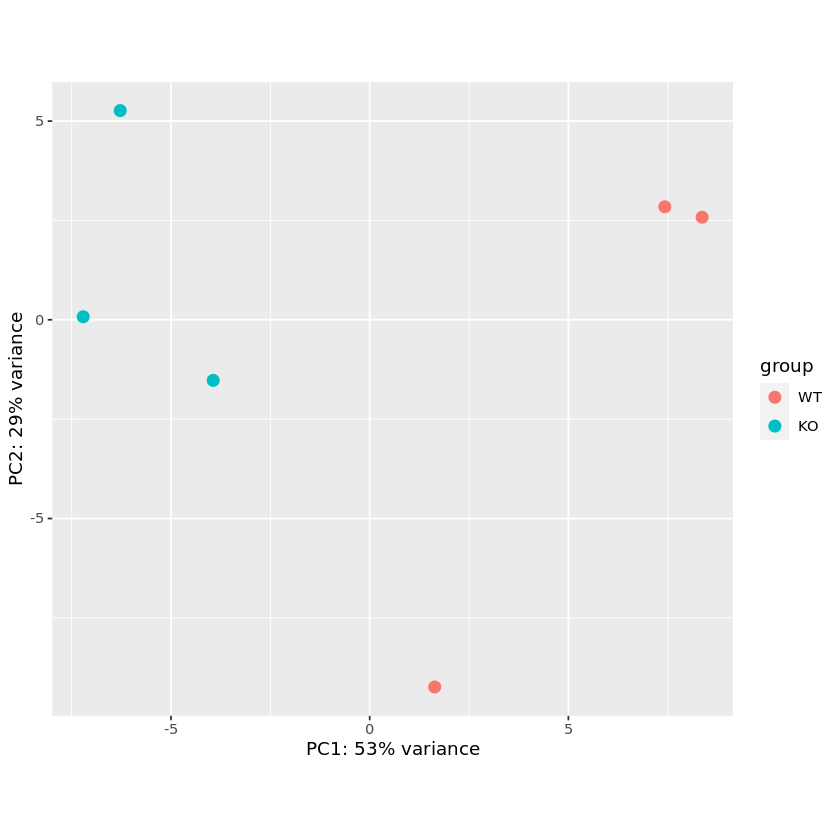

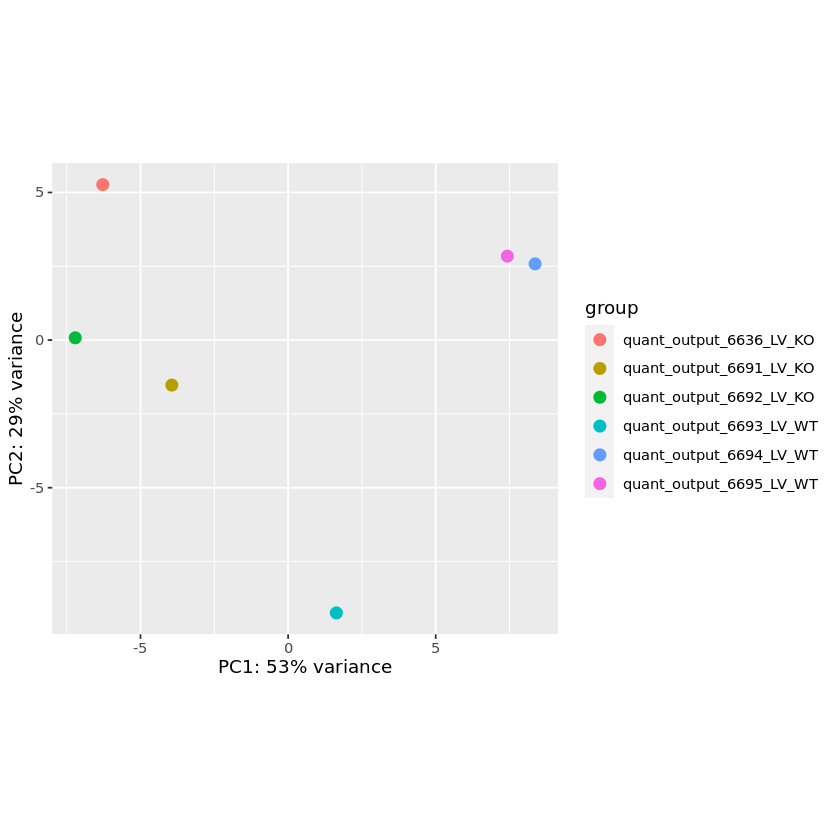

In [12]:
# QC the data with principal component analysis (PCA) plots
# It's useful to use transformed count data for PCA. The function rlog performs a regularized 
# logarithm on the count data that accounts for differences in library size across samples 
# and improves the statistical properties of the data
rld <- rlog(ddsGeneBulk_lv, blind=FALSE)
# Create PCA plots of the first 2 principle components (PCs)
# First, color by condition (WT vs KO)
plotPCA(rld, intgroup=c("condition")) # intgroup = interesting groups
# Second, color by sample name
plotPCA(rld, intgroup=c("sample")) 

# Inspect the differentially expressed genes
<font color="#445555"> Here, we identify strongly differentially regulated genes, i.e., abs(log<sub>2</sub> FC) > 2 and output the results to files. Specifically, we
    
<font color="#445555">   1. Run a log<sub>2</sub> fold change transformation on the gene counts   
<font color="#445555">    2. Identify genes expressed higher in WT vs. KO (log<sub>2</sub> FC > 2)    
<font color="#445555">    3. Output this information into a text file, one gene per line    
<font color="#445555">    4. Identify genes expressed lower in WT vs. KO with (log<sub>2</sub> FC < -2)    
<font color="#445555">    5. Output this information into a text file, one gene per line   

In [13]:
# Run a log2FC transformation on the gene counts
# Note the coef parameter is the condition defined above
res_L2FC_LVgene <- lfcShrink(ddsGeneBulk_lv, coef="condition_KO_vs_WT", type="apeglm")

# Identify genes expressed higher in WT vs. KO (log2 FC > 2)
LV_L2FC_greater2 <- subset(res_L2FC_LVgene, res_L2FC_LVgene$log2FoldChange > 2) # Can change threshold to make more stringent
LV_L2FC_greater2_names <- rownames(LV_L2FC_greater2)

# Output this information into a text file, one gene per line
write.table(LV_L2FC_greater2_names, file="output/LV_L2FC_greater2_names.txt", quote=FALSE, sep="\t", row.names=FALSE)

# Identify genes expressed lower in WT vs. KO with (log2 FC < -2)
LV_L2FC_lessneg2 <- subset(res_L2FC_LVgene, res_L2FC_LVgene$log2FoldChange < -2) # Can change threshold to make more stringent
LV_L2FC_lessneg2_names <- rownames(LV_L2FC_lessneg2)

# Output this information into a text file, one gene per line
write.table(LV_L2FC_lessneg2_names, file="output/LV_L2FC_lessneg2_names.txt", quote=FALSE, sep="\t", row.names=FALSE)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



# Transfom and write the gene x sample expression matrices to files
<font color="#445555">Here, we will output two matrices representing the gene expression dataset.  In both matrices, the columns represent samples and rows represent genes that passed our filtration steps above.  In the first matrix, element *a<sub>ij</sub>* will be the raw, untransformed expression of gene *i* in sample *j*.  In the second matrix, element *a<sub>ij</sub>* will be the log<sub>2</sub> transformed expression value. Specifically, we
    
1. Run a log<sub>2</sub> fold change transformation on the gene expression matrix    
2. Output this matrix to a file in the output directory
3. Without log<sub>2</sub> transformation     
4. Output this matrix to a file in the output directory   

In [14]:
# Run a log2 fold change transformation on the gene expression matrix
log2normddsGeneBulk_lv <- rlog(ddsGeneBulk_lv)
log2normCountMatrixddsGeneBulk_lv <-  assay(log2normddsGeneBulk_lv) 

# Output this matrix to a file in the output directory
write.table(log2normCountMatrixddsGeneBulk_lv, file="output/2020_10_08_log2normCountMatrixddsGeneBulkLV_KO_vs_WT.txt", sep="\t", row.names = TRUE, col.names = TRUE, quote = FALSE, append = FALSE)

# Without log2 transformation:
ddsGeneBulk_lv <- estimateSizeFactors(ddsGeneBulk_lv)
normCountMatrixddsGeneBulk_lv <- counts(ddsGeneBulk_lv, normalized=TRUE)  

# Output this matrix to a file in the output directory
write.table(normCountMatrixddsGeneBulk_lv, file="output/2020_10_08_normCountMatrixddsBulkLV_KO_vs_WT.txt", sep="\t", row.names = TRUE, col.names = TRUE, quote = FALSE, append = FALSE)

using 'avgTxLength' from assays(dds), correcting for library size



# Volcano plots comparing DE transcripts across the condition
<font color="#445555">Now that we've processed the data  and log<sub>2</sub> transformed our gene expression matrix, we are ready to plot our data!  First we will use the excellent EnhancedVolcano package (slide 42), which ingests the DEseq2 results object (which is called res_L2FC_LVgene, and was made using the results function in section 6 above), and takes some parameters.  For more information on this package, see the documentation here: https://bioconductor.org/packages/release/bioc/html/EnhancedVolcano.html

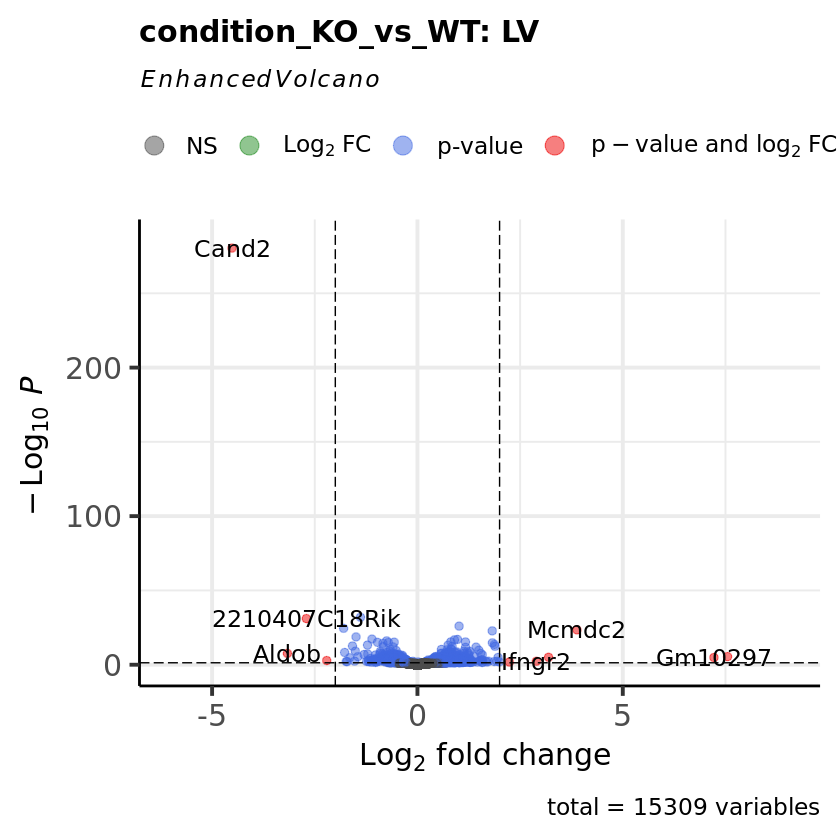

In [15]:
EnhancedVolcano(res_L2FC_LVgene,
                lab = rownames(res_L2FC_LVgene),
                x = "log2FoldChange",
                y = "padj", #this is important!  you want to plot the P-value adjusted for multiple testing corrections
                pCutoff = 0.05, #standard, but adjustable if you want a more or less permissive value
                FCcutoff = 2, #fold change cutoff - the two lines to the left/right of the center of the "volano"
                title= "condition_KO_vs_WT: LV") #give an informative title

# Heatmaps using normalized count matrix on genes with a L2FC +/- 2
<font color="#445555">Here, we return to the L2FC lists we output in step 7.  We can plot the log<sub>2</sub> fold change transformed values for expression of these genes across all 6 samples to get a heatmap illustrating what genes increase and decrease in expression across our dataset.  The code below first produces a dendrogram, and a very basic heatmap.  Then using the heatmap.2 package, we will plot a more complex heatmap which has an informative color legend.  </font>
    
1. <font color="#445555">Generate a dendrogram for the columns (samples) using the dist and hclust functions
    
2. <font color="#445555">Select the subset of genes that are l2FC up/down to heatmap plot.
    
3. <font color="#445555">Plot a basic heatmap (without a directly attached dendrogram)
    
4. <font color="#445555">A final heatmap using the Heatmap.2 package

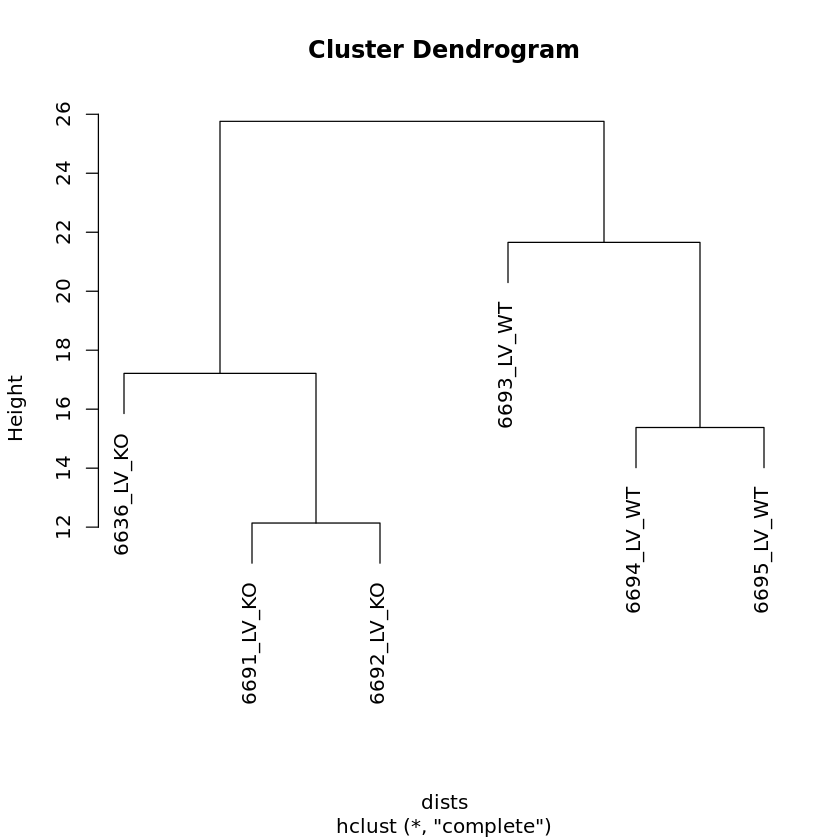

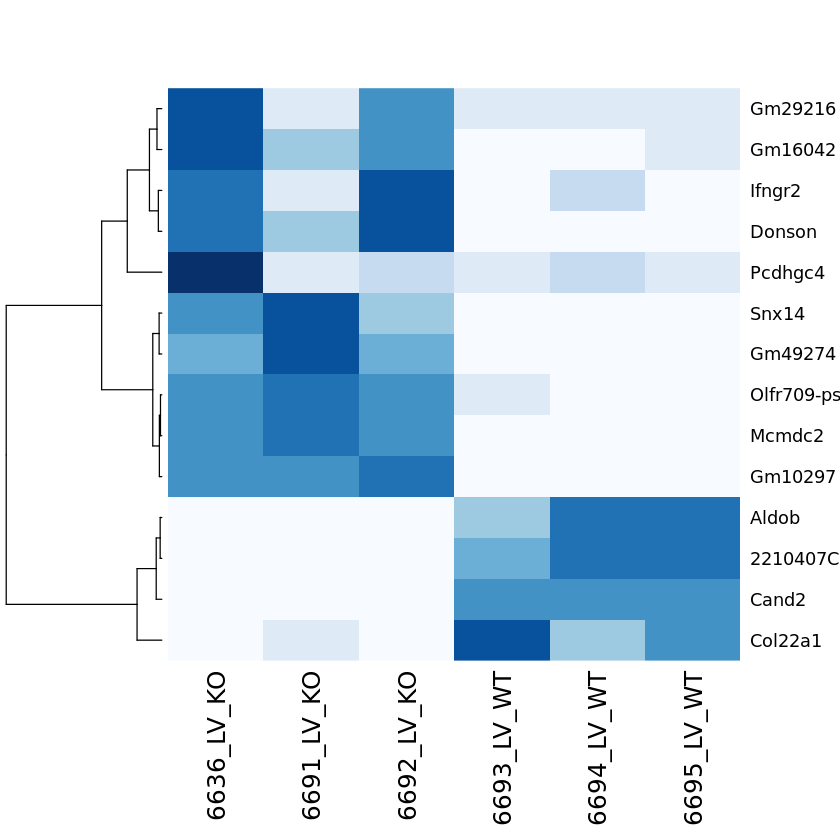

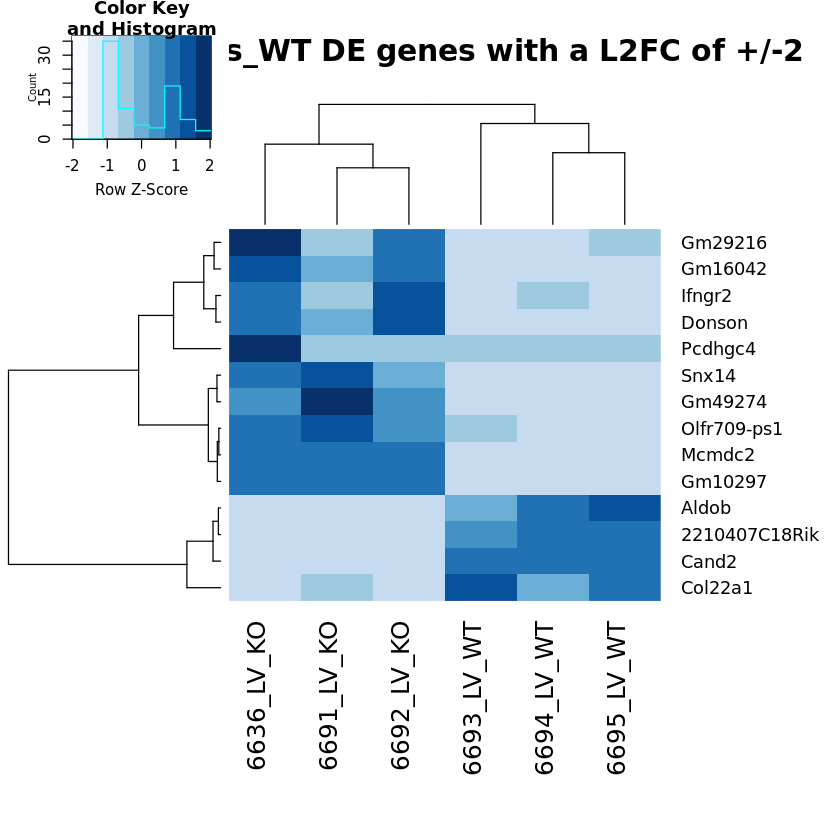

In [19]:
# Basic heatmap to compare genes with a L2FC of +/- 2 across all samples
log2normddsGeneBulkLV <- rlog(ddsGeneBulk_lv)
log2normCountMatrixddsGeneBulkLV <-  assay(log2normddsGeneBulkLV)

# Generate a dendrogram for the columns (samples) using the dist and hclust functions
dists <- dist(t(log2normCountMatrixddsGeneBulkLV))
plot(hclust(dists))

# Select the subset of genes that are l2FC up/down to heatmap plot:
LV_l2fc_DE <- append(LV_L2FC_greater2_names, LV_L2FC_lessneg2_names)
log2normCountMatrixddsGeneLV_DEgenes <- subset(log2normCountMatrixddsGeneBulkLV, rownames(log2normCountMatrixddsGeneBulkLV) %in% LV_l2fc_DE)

# Both methods below generate heatmaps, but the heatmap.2 also generates a density plot and legend, highly useful.
# Heatmaps
cor_t <- 1 - cor(t(log2normCountMatrixddsGeneLV_DEgenes)) # works well, isolates differences...
distancet <- as.dist(cor_t)
hclust_complete <- hclust(distancet, method = "complete")
dendcomplete <- as.dendrogram(hclust_complete)
columnDend <- as.dendrogram(hclust(dist(t(log2normCountMatrixddsGeneBulkLV))))
heatmap(as.matrix(log2normCountMatrixddsGeneLV_DEgenes), Rowv=dendcomplete, Colv=NA, scale="row", col=brewer.pal(9,"Blues"))

# Heatmap.2 with density plot as legend: works nicely...
heatmap.2(as.matrix(log2normCountMatrixddsGeneLV_DEgenes),
          main = "LV: KO_vs_WT DE genes with a L2FC of +/-2", # heat map title
          margins =c(12,9),     # widens margins around plot
          col=brewer.pal(9,"Blues"),       # use on color palette defined earlier
          trace="none",         # turns off trace lines inside the heat map
          scale = "row",
          dendrogram="both",     # only draw a row dendrogram
          Rowv=dendcomplete,
          Colv=columnDend)            # turn off column clustering

# Extended analysis: Pathway analysis of L2FC +/- 2 gene lists using topGO 

<font color="#445555">This section takes the log<sub>2</sub> fold change gene lists generated in section 6, and makes several objects which allow us to examine the enrichment of different GO pathways in this data.
    
1. <font color="#445555">Build an object of gene names and P-values from L2FC genes
2. <font color="#445555">Build an object of all gene IDs and P-values from all genes not filtered for low expression in step 4
3. <font color="#445555">Read in a table which links gene IDs with Gene Ontology terms, and convert this to list format
4. <font color="#445555">Run TopGO on our dataset, using the objects generated above
5. <font color="#445555">Plot the GO results as a system of nodes, and examine the results in table format


In [20]:
# Build an object of gene IDs and P-values for DEG with a L2FC > 2
LV_L2FC_greater2 #results table from LV, selected for a log2FC > 2

# Make a list of gene names and adjusted p-values for l2FC genes
LV_L2FC_greater2adjPdf <- LV_L2FC_greater2$padj
names(LV_L2FC_greater2adjPdf) <- as.character(rownames(LV_L2FC_greater2))

# Gene universe: all gene IDs in the total dataset after filtration for low counts
geneUniverse <- res_L2FC_LVgene$padj
names(geneUniverse) <- as.character(rownames(res_L2FC_LVgene))

#https://www.biostars.org/p/102088/
# Generate a geneID2GO term list for all the genes in our "universe" using biomart
#EG2GO <- getBM(mart=mart, filters="external_gene_name", attributes=c('external_gene_name','go_id'), values=rownames(res_L2FC_LVgene), useCache=FALSE, verbose=TRUE)
EG2GO <- read.table("mmusculus_gene2goTerm.txt", header=TRUE)

# Convert from table format to list format
geneID2GO <- by(EG2GO$go_id,
                EG2GO$external_gene_name,
                function(x) as.character(x))

log2 fold change (MAP): condition KO vs WT 
Wald test p-value: condition KO vs WT 
DataFrame with 10 rows and 5 columns
               baseMean log2FoldChange     lfcSE      pvalue        padj
              <numeric>      <numeric> <numeric>   <numeric>   <numeric>
Donson          9.22834        6.60632  2.624684 4.47119e-06          NA
Gm10297        12.30750        7.21877  2.607131 1.74290e-07 1.42064e-05
Gm16042         9.51482        3.88637  1.240055 2.31237e-04          NA
Gm29216     32727.89201        7.55051  1.544795 3.09893e-08 3.40451e-06
Gm49274         4.60999        4.94586  2.688419 4.48087e-04          NA
Ifngr2         20.09366        2.89565  1.251410 2.82088e-04 4.99845e-03
Mcmdc2         69.32141        3.88270  0.366557 1.57026e-27 3.30644e-24
Olfr709-ps1    24.61940        3.19245  0.665018 1.13824e-07 9.91762e-06
Pcdhgc4        25.80194        2.23874  1.243777 1.39490e-03 1.61532e-02
Snx14           6.94528        5.98278  2.610512 3.11057e-05          NA

In [21]:
str(geneUniverse)
str(LV_L2FC_greater2adjPdf)

 Named num [1:15309] 0.9286 0.0712 0.89 0.7077 0.6558 ...
 - attr(*, "names")= chr [1:15309] "0610009B22Rik" "0610010F05Rik" "0610010K14Rik" "0610012G03Rik" ...
 Named num [1:10] NA 1.42e-05 NA 3.40e-06 NA ...
 - attr(*, "names")= chr [1:10] "Donson" "Gm10297" "Gm16042" "Gm29216" ...


In [22]:
#Running the topGO analysis in a single "wrapper" function
LVbulkGOdata <- new("topGOdata",
                    description = "LV DEG with l2FC > 2",
                    ontology = "BP",
                    allGenes = geneUniverse,
                    geneSel = topDiffGenes, #or rownames(LV_L2FC_greater2)
                    nodeSize = 10,
                    annot = annFUN.gene2GO,
                    gene2GO = geneID2GO)



Building most specific GOs .....

	( 11429 GO terms found. )


Build GO DAG topology ..........

	( 14939 GO terms and 33752 relations. )


Annotating nodes ...............

	( 13803 genes annotated to the GO terms. )




			 -- Classic Algorithm -- 

		 the algorithm is scoring 5147 nontrivial nodes
		 parameters: 
			 test statistic: fisher




Description: LV DEG with l2FC > 2 
Ontology: BP 
'classic' algorithm with the 'fisher' test
5997 GO terms scored: 704 terms with p < 0.01
Annotation data:
    Annotated genes: 13803 
    Significant genes: NA 
    Min. no. of genes annotated to a GO: 10 
    Nontrivial nodes: 5147 

$dag
A graphNEL graph with directed edges
Number of Nodes = 15 
Number of Edges = 19 

$complete.dag
[1] "A graph with 15 nodes."


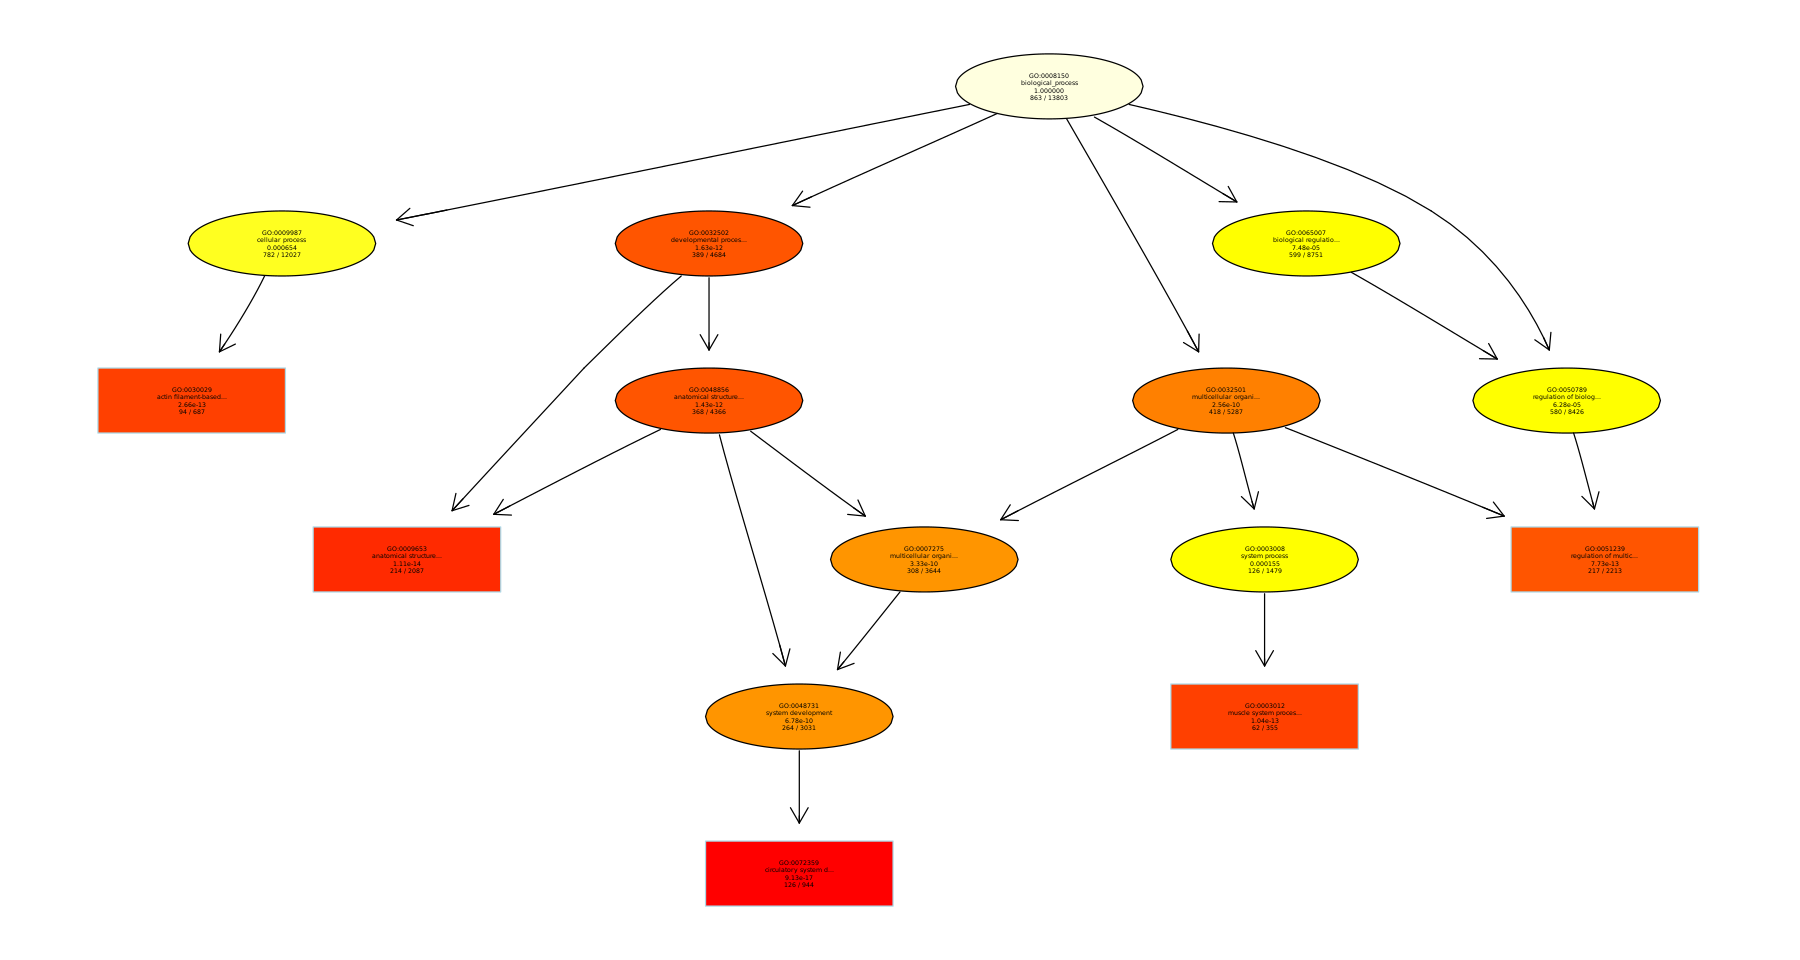

In [23]:
# Classical enrichment analysis for representing overrepresentation of GO-terms
options(repr.plot.width=15, repr.plot.height=8) #for optimal width by height for the resulting plot
resultFisher <- runTest(LVbulkGOdata, algorithm = "classic", statistic = "fisher")
resultFisher #display the results
                
#Kolmogorov-Smirnov test (similar to GSEA) throws an error using this data....
#resultKS <- runTest(LVbulkGOdata, algorithm = "classic", statistic = "ks")
#Kolmogorov-Smirnov test (similar to GSEA) with elim method            
#resultKS.elim <- runTest(LVbulkGOdata, algorithm = "elim", statistic = "ks")
                
# Generate a table of these results:     
allRes <- GenTable(LVbulkGOdata, classicFisher = resultFisher,
                   orderBy = "classicFisher", ranksOf = "classicFisher", topNodes = 10)                

# node plot
showSigOfNodes(LVbulkGOdata, score(resultFisher), firstSigNodes = 5, useInfo = 'all')

In [24]:
# Examining the table of results returned from the wrapper function above
allRes

GO.ID      Term                                        Annotated Significant
1  GO:0072359 circulatory system development               944      126        
2  GO:0009653 anatomical structure morphogenesis          2087      214        
3  GO:0003012 muscle system process                        355       62        
4  GO:0030029 actin filament-based process                 687       94        
5  GO:0051239 regulation of multicellular organismal p... 2213      217        
6  GO:0048856 anatomical structure development            4366      368        
7  GO:0032502 developmental process                       4684      389        
8  GO:0016477 cell migration                              1197      136        
9  GO:0048870 cell motility                               1283      143        
10 GO:0050896 response to stimulus                        6330      493        
   Expected classicFisher
1  NA       9.1e-17      
2  NA       1.1e-14      
3  NA       1.0e-13      
4  NA       2.7e-13      
5  NA       7.7e-13      
6  NA       1.4e-12      
7  NA       1.6e-12      
8  NA       1.9e-12      
9  NA       2.1e-12      
10 NA       4.8e-12

# Bar Plots of GO BP enriched terms
<font color="#445555">Finally, we will make a bar plot using ggplot2 to plot the top 10 enriched GO terms from the table visible in the cell above!

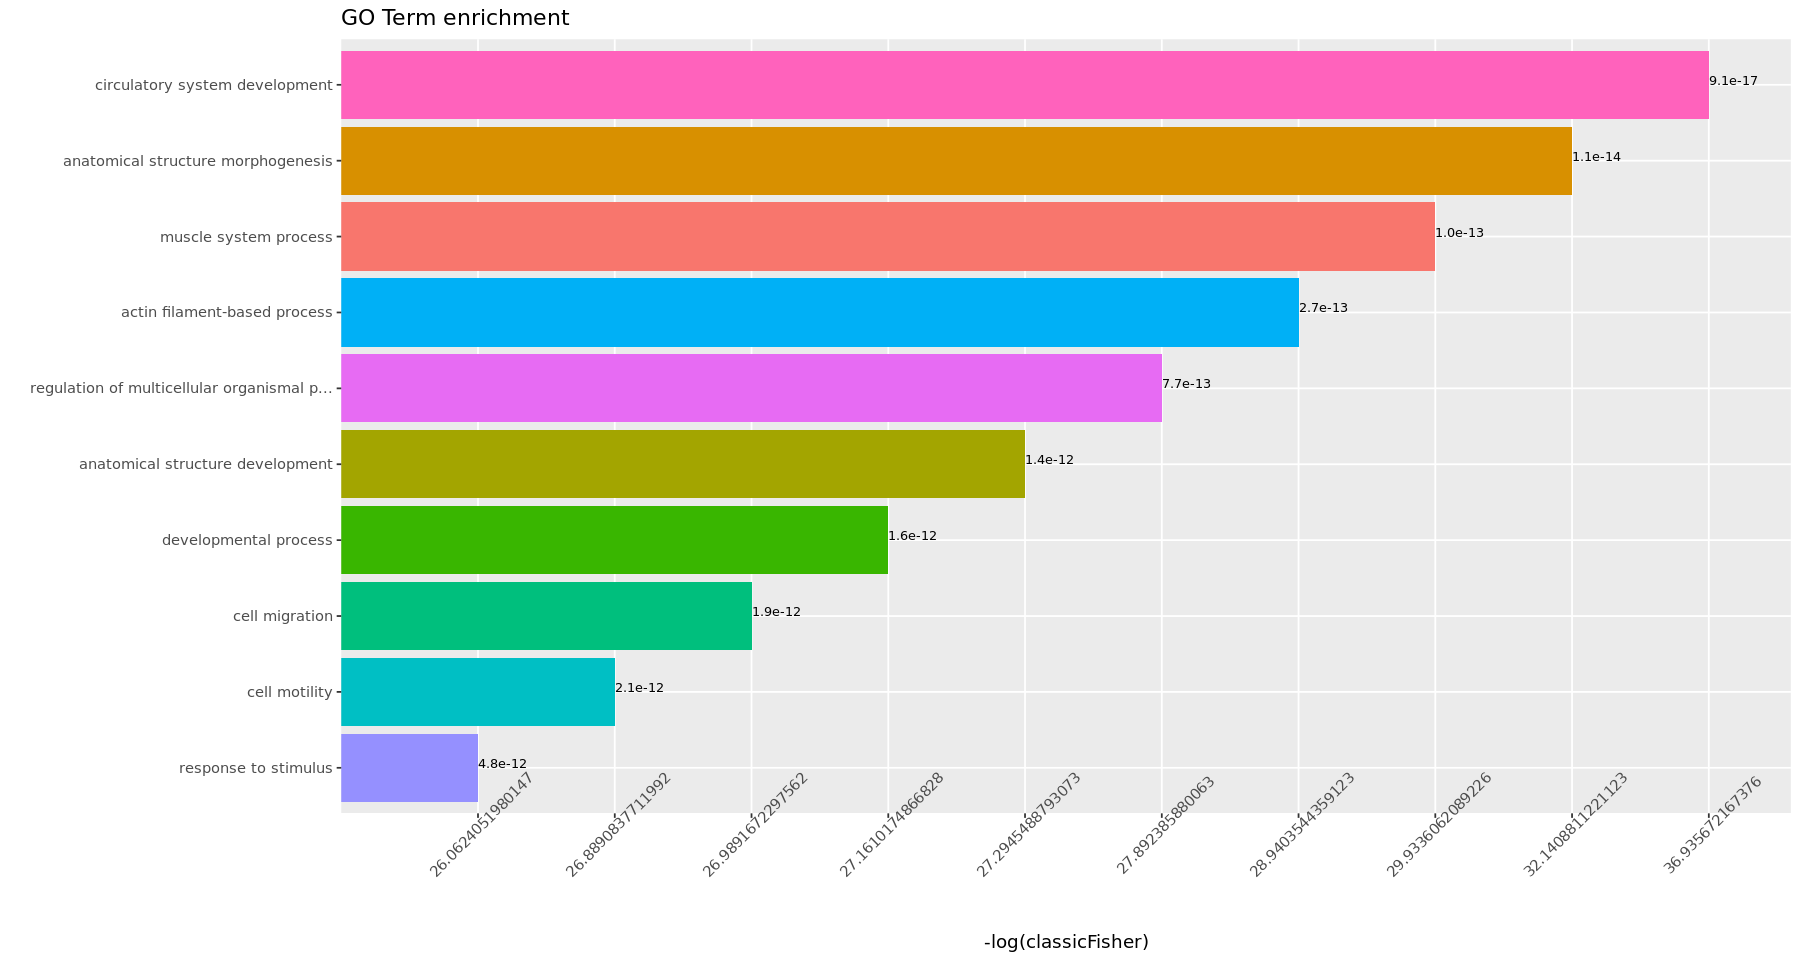

In [25]:
# Bar plot the top 10 enriched GO-terms, bar length is the -log10 P-value
options(repr.plot.width=15, repr.plot.height=8) #for optimal width by height for the resulting plot

# Convert p-values from strings to numeric
allRes$classicFisher <- as.numeric(allRes$classicFisher)

# To plot the GO terms by P-value, first sort the table by P-value, then "save" this order by converting
# the GO terms to a factor with this same ordering
allRes <- allRes[order(allRes$classicFisher, decreasing=TRUE), ]
allRes$Term = factor(allRes$Term, levels=allRes$Term)

# Create a bar plot of the GO terms x -log10(P-value)
# Bars are colored by -log10(P-value as well)
p <- ggplot(allRes, aes(x=Term, y=-1*log10(classicFisher), fill=-1*log10(classicFisher))) +
  geom_col(position = "identity") + 
  coord_flip() +
  labs(x="GO term", y="-log10(P-value)", title="GO Term enrichment") +
  scale_fill_viridis_c(name="-log10(P-value)") +
  theme_classic() +
  theme(text=element_text(size=21))
p

In [34]:
#Examine all of the files in the output directory
dir("output")

[1] "2020_10_08_KO_vs_LV_CAND2_DEseq2_results.csv"            
[2] "2020_10_08_log2normCountMatrixddsGeneBulkLV_KO_vs_WT.txt"
[3] "2020_10_08_normCountMatrixddsBulkLV_KO_vs_WT.txt"        
[4] "LV_L2FC_greater2_names.txt"                              
[5] "LV_L2FC_lessneg2_names.txt"

In [ ]:
# Output all session information
devtools::session_info()